In [12]:
import utilities
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Convolution2D, MaxPooling2D, Flatten, Dense, Dropout , SpatialDropout2D
from tensorflow.keras.layers import AveragePooling2D, Activation
from tensorflow.keras.callbacks import History
import numpy as np
import pandas as pd
import os
from tensorflow import keras
from  tensorflow.keras import optimizers
from tensorflow.keras import losses
from tensorflow.keras.regularizers import l1_l2, l1,l2
from tensorflow.keras.models import model_from_json
from sklearn.utils import class_weight
import keras_tuner as kt
from keras_tuner import RandomSearch
from keras_tuner.engine.hyperparameters import HyperParameters
import pyprog
import os

def set_gpus(gpus_number="1,2"):
    os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
    os.environ["CUDA_VISIBLE_DEVICES"] = gpus_number
    
SETTINGS_DIR = os.path.dirname(os.path.realpath('__file__'))

speaker_name=input("Which speaker do you want to train/test? ")

#train_set_path = SETTINGS_DIR+'/image/high_int/Train/'
#test_set_path = SETTINGS_DIR+"/image/high_int/Test/"

train_set_path = SETTINGS_DIR+'/images/Dysarthric/Train/'+speaker_name
test_set_path = SETTINGS_DIR+"/images/Dysarthric/Test/"+speaker_name

dnn_file_name_structure = SETTINGS_DIR +"/Models/cnn_"+speaker_name+".json"
training_dynamics_path = SETTINGS_DIR+'/Training Performance/TrainingDynamics'+speaker_name+'.csv'
dnn_file_name_weights = SETTINGS_DIR +  "/Models/cnn_weight_"+speaker_name+".h5"

batch_size=256
image_input_size=(150,150)
vocab_size = utilities.get_no_folders_in_path(test_set_path)
print ("Vocabulary Size:",vocab_size)

def model_compile(model,lr=0.001):
    model.compile(loss=losses.categorical_crossentropy,
                          optimizer=optimizers.Adam(lr),
                          metrics=['accuracy'])
    
def get_model(hp):
    droprates=hp.Float('droprate', 0.2, 0.75, sampling='linear')
    learning_rate=hp.Float('lr', 1e-4, 1e-2, sampling='log')
    first_train=hp.Choice('first_train', values=['2','3','4'])
    model = FreezeLayers(droprates, load_model(learning_rate=learning_rate), top_unfrozen_layer_name="separable_conv2d_"+ first_train)

    return model

def predict_an_image(image_path, model):
    
    from tensorflow.keras.preprocessing import image

    test_image = image.load_img(image_path, target_size = image_input_size)
    test_image = image.img_to_array(test_image)
    test_image = np.expand_dims(test_image, axis = 0) 

    y_pred = model.predict_classes(test_image,batch_size)[0]
    classes =training_set.class_indices
    for key, value in classes.items():
        if value==y_pred:
            break       

    pred_key=utilities.dictionary .index [ utilities.dictionary  ['FILE NAME'] == key ] 
    predicted_word=utilities.dictionary .iloc[pred_key[0],0]
    # Get true label
    true_key=true_key=utilities.file_to_index(image_path)
    true_word = utilities.dictionary .iloc[true_key,0]
    #print("Predicted:",predicted_word,", True:",true_word)
    return predicted_word, true_word

def read_epoch():
    if os.path.exists(training_dynamics_path):
        
        # First check the csv file has headres and add then if missing
        try:
            training_dynamics=pd.read_csv(training_dynamics_path)
            training_dynamics["Epoch"][len(training_dynamics)-1]
        except:
            df = pd.read_csv(training_dynamics_path, header=None, index_col=None)
            df.columns = columns=["","Epoch","TrainingLoss", "TrainingAccuracy","ValidationLoss","ValidationAccuracy"]
            df.to_csv(training_dynamics_path, index=False)
        training_dynamics=pd.read_csv(training_dynamics_path)               
        return training_dynamics["Epoch"][len(training_dynamics)-1]
        
    else:
        return 0

def load_model(learning_rate=0.001):
    # Loading the CNN
    json_file = open(dnn_file_name_structure, 'r')
    loaded_model_json = json_file.read()
    json_file.close()
    model = model_from_json(loaded_model_json)
    # load weights into new model
    model.load_weights(dnn_file_name_weights)
    print(learning_rate)
    model_compile(model,learning_rate)
    return model

def save_model(model,is_max_val_inclluded=False,max_val=None, ep=None):
    # Save/overwrite the model
    if (is_max_val_inclluded):
        json_file_name = SETTINGS_DIR+"/Models/cnn_"+speaker_name+"_"+str(max_val)+"_"+str(ep)+".json"
        wights_file_name = SETTINGS_DIR+"/Models/cnn_weight_"+speaker_name+"_"+str(max_val)+"_"+str(ep)+".h5"
        # Delete previously stored models for this speaker
        for directory, s, files in os.walk(SETTINGS_DIR+"/Models/"):
            for f in files:
                if speaker_name in f:
                    file_path=directory+"/"+f
                    os.remove(file_path)
    else:
        json_file_name = dnn_file_name_structure
        wights_file_name = dnn_file_name_weights
    
    model_json = model.to_json()
    with open(json_file_name, "w") as json_file:
        json_file.write(model_json)
    # serialize weights to HDF5
    model.save_weights(wights_file_name)
    
def save_training_dynamics(epoch,history,with_header=False):
    training_dynamics=pd.DataFrame(
        data = [ [epoch, history.history['loss'][0] ,  history.history['accuracy'][0],  
                history.history['val_loss'][0],  history.history['val_accuracy'][0] ]],
        columns=["Epoch","TrainingLoss", "TrainingAccuracy","ValidationLoss","ValidationAccuracy"]
    )
    if (with_header):
        with open(training_dynamics_path, 'a') as csv_file:
            training_dynamics.to_csv(csv_file, header=True)
    else:
        with open(training_dynamics_path, 'a') as csv_file:
            training_dynamics.to_csv(csv_file, header=False)
            
def visualize_training():
    import matplotlib.pyplot as plt
    if (os.path.isfile(training_dynamics_path) == False ):
        print ("Training dynamics file is not found.")
        return
    try:
        training_dynamics=pd.read_csv(training_dynamics_path)
        loss_values = training_dynamics["TrainingLoss"]
        val_loss_values = training_dynamics["ValidationLoss"]
        epochs = range(1, len (training_dynamics['Epoch'])+1)
        plt.plot(epochs, loss_values, 'g', label='Training loss')
        plt.plot(epochs, val_loss_values, 'b', label='Validation loss')
        plt.title('Training and validation loss')
        plt.xlabel('Epochs')
        plt.ylabel('Loss')
        plt.legend()
        plt.show()
        # Ploting Accuracy
        loss_values = training_dynamics["TrainingAccuracy"]
        val_loss_values = training_dynamics["ValidationAccuracy"]
        epochs = range(1, len (training_dynamics['Epoch'])+1)
        plt.plot(epochs, loss_values, 'g', label='Training loss')
        plt.plot(epochs, val_loss_values, 'b', label='Validation loss')
        plt.title('Training and validation Accuracy')
        plt.xlabel('Epochs')
        plt.ylabel('Loss')
        plt.legend()
        plt.show()
     
    except:
        df = pd.read_csv(training_dynamics_path, header=None, index_col=None)
        df.columns = ["","Epoch","TrainingLoss", "TrainingAccuracy","ValidationLoss","ValidationAccuracy"]
        df.to_csv(training_dynamics_path, index=False)
        visualize_training()
    
def get_train_test_sets():
        from tensorflow.keras.preprocessing.image import ImageDataGenerator
        
        # https://fairyonice.github.io/Learn-about-ImageDataGenerator.html
        train_datagen = ImageDataGenerator(
                    rescale=1./255,
            width_shift_range=0.30,
            shear_range=0.2,
            zoom_range=0.2,
            fill_mode='nearest',
            horizontal_flip=False)
        
        test_datagen = ImageDataGenerator(rescale=1./255)
        
        # If shuffle=False then the validation results will be different from classifier.predict_generator()
        print ("Setting training date...")
        training_set = train_datagen.flow_from_directory(
            train_set_path,
            target_size=image_input_size,
            batch_size=batch_size,
            class_mode='categorical',
            shuffle=True)
        
        print ("Setting testing date...")
        test_set = test_datagen.flow_from_directory(
           test_set_path,
            target_size=image_input_size,
            batch_size=batch_size,
            class_mode='categorical',
            shuffle=False)
        return training_set, test_set
    
def test_generator(test_set_generator):
    steps=test_set_generator.samples/batch_size
    model = load_model()

    y_pred = model.evaluate_generator(test_set_generator, steps = steps, verbose = 1)
    y_test = test_set_generator.classes
    correct_classifications=0
    for pred,label in zip(y_pred, y_test):
        if pred.argmax()==label:
            correct_classifications+=1
    print ("Loss:", y_pred[0])
    print ("Acuracy:", y_pred[1] *100,"%")
    return 

def manual_testing():
    model = load_model() 
    #test_path = SETTINGS_DIR+"/images/Control/Test"
    #test_path = SETTINGS_DIR+"/images/Dysarthric/Test/F05"
    #test_path = SETTINGS_DIR+"/images/Dysarthric/Test/M06"
    #test_path = SETTINGS_DIR+"/images/Dysarthric/Test/M10"
    #test_path = SETTINGS_DIR+"/images/Control/Test"
    test_path=test_set_path
    
    correct_classifications=0
    i=0
    prog = pyprog.ProgressBar("Predicting ", " Done", utilities.get_no_files_in_path(test_path))
    # Show the initial status
    prog.update()
    no_processed=i
    for directory, s, files in os.walk(test_path):
            for f in files:
                file_path=directory+"/"+f
                if ("jpg" in f):                
                    predicted_word, true_word = predict_an_image(file_path,model)
                    #print (predicted_word,true_word)
                    if (predicted_word==true_word):
                        correct_classifications+=1
                    i+=1
                    prog.set_stat(i)
                    prog.update()

    prog.end()
    print ("Testing acuracy:", correct_classifications/i *100,"%")
    
def train(ideal_loss=0.01, is_dnn_structure_changned=False, learning_rate=0.001, max_epoch=50, enabled_trasfer_learning=False):
        
        # Check if speaker_name is set
        if (speaker_name==""):
            print ("Please set speaker_name and try again.")
            return
            
        is_new_dnn=False
        
        history = History()
        
        print("=================================================")
        
        if (os.path.isfile(dnn_file_name_structure) and
                (os.path.isfile(dnn_file_name_weights)) and 
                (is_dnn_structure_changned == False)):
            # load the previosly trained DNN
            if (enabled_trasfer_learning):
                # Enable Transfer Learning
                print ("Transfer learning is enabled.")
                model = FreezeLayers(load_model(learning_rate=learning_rate),
                                     top_unfrozen_layer_name="separable_conv2d_3" ) 
            else:
                print ("Transer learning is disabled.")
                model = load_model(learning_rate=learning_rate)
            print("CNN is loaded.")
        else:
            # Create a new model
            model =  get_model()                    
            print("CNN is created")
            # Erase the training_dynamic_csv file
            if os.path.exists(training_dynamics_path):
                os.remove(training_dynamics_path)
            is_new_dnn=True
            model_compile(model)
        
        ep= read_epoch()+1
        PringFrozenLayers(model)
        history=model.fit(
            training_set,
            steps_per_epoch=training_set.samples/batch_size, epochs=1,                            
                             validation_data=test_set,
                             validation_steps=test_set.samples/batch_size,
                             workers=10, 
                             max_queue_size=10)
        
        save_training_dynamics(ep,history,with_header=is_new_dnn)
       
        max_val = history.history['val_accuracy'][0]
        
        while (history.history['loss'][0] >= ideal_loss):
            print("Epoch", ep)
            history=model.fit(
            training_set,
            steps_per_epoch=training_set.samples/batch_size,epochs=1,
                             validation_data=test_set,
                             validation_steps=test_set.samples/batch_size,
                             workers=10,
                             max_queue_size=10)

            # Save the max model, if any            
            if (history.history['val_accuracy'][0]>max_val):
                max_val= history.history['val_accuracy'][0]
                save_model(model=model,is_max_val_inclluded=True,max_val=max_val,ep=ep)
             
            # Save/overwrite the model
            save_model(model)
               
            ep += 1
            save_training_dynamics(ep,history,with_header=False)        

            # stop the traning if certain accuracy is reached
            #if (ep%10==0):
                #manual_testing()   
            #if   (history.history['val_accuracy'][0]>0.92):
              #  break
            if (history.history['loss'][0]<ideal_loss):
                   break
            
            if (ep > max_epoch):
                break

        return history
    
    # Transfer learning: freeze top layers but unfreeze all layers below the given layer   
def FreezeLayers(droprate, model, top_unfrozen_layer_name):
    
    model.trainable=True
    set_trainable = False
    for layer in model.layers:
        # Increase dropout rate
        if "dropout" in layer.name:
            layer.rate=droprate
            print (layer.name,"dropout rate updated to",layer.rate)
        if (layer.name==top_unfrozen_layer_name):
            set_trainable=True

        if (set_trainable):
            print (layer.name," NOT FREEZED")
            layer.trainable=True
        else:
            print (layer.name," FREEZED")
            layer.trainable=False
        #if (layer.name=="dense_1"):
            #layer.trainable = False
    #model = add_new_dense(model)
    model_compile(model)
    return model

# add a new dense layer
def add_new_dense(model):
    new_model=Sequential()

    for layer in model.layers[:-1]:
        layer.name=layer.name+"_old"
        new_model.add(layer)
    new_model.add(Dense(units = 1024, activation='relu' ))
    new_model.add(Dropout(0.5))
    new_model.add(Dense (units=vocab_size, activation='softmax' ))
    return new_model

def PringFrozenLayers(model):
     for layer in model.layers:
            print ("Layer:",layer.name, "Frozen:",not layer.trainable)
            
def training_restart_initalize():
    import shutil
    shutil.copyfile(SETTINGS_DIR+"/Models/cnn_control.json", dnn_file_name_structure)
    shutil.copyfile(SETTINGS_DIR+"/Models/cnn_weight_control.h5", dnn_file_name_weights)
    if (os.path.isfile(training_dynamics_path)):
        os.remove(training_dynamics_path)
    print ("Ready for training...")

# Load X and y
training_set, test_set =get_train_test_sets()


!find '.' -name '*.ipynb_checkpoints' -exec rm -r {} +

Which speaker do you want to train/test? M08
Vocabulary Size: 155
Setting training date...
Found 930 images belonging to 155 classes.
Setting testing date...
Found 465 images belonging to 155 classes.


In [13]:
# Enable this if you want to train the model for this speaker from scracth. 
# Otherwise, the previously trained model is continued training.
# This loads the base, control model.
training_restart_initalize()
set_gpus("2")

Ready for training...


In [14]:
tuner_search=RandomSearch(get_model,
                          objective='val_accuracy',
                          max_trials=40,directory='tuner_model_high-int',
                          project_name="dyser_high-int")

INFO:tensorflow:Reloading Oracle from existing project tuner_model_high-int/dyser_high-int/oracle.json
0.0001
separable_conv2d  FREEZED
spatial_dropout2d dropout rate updated to 0.2
spatial_dropout2d  FREEZED
batch_normalization  FREEZED
max_pooling2d  FREEZED
separable_conv2d_1  FREEZED
spatial_dropout2d_1 dropout rate updated to 0.2
spatial_dropout2d_1  FREEZED
batch_normalization_1  FREEZED
separable_conv2d_2  NOT FREEZED
spatial_dropout2d_2 dropout rate updated to 0.2
spatial_dropout2d_2  NOT FREEZED
batch_normalization_2  NOT FREEZED
max_pooling2d_1  NOT FREEZED
separable_conv2d_3  NOT FREEZED
spatial_dropout2d_3 dropout rate updated to 0.2
spatial_dropout2d_3  NOT FREEZED
batch_normalization_3  NOT FREEZED
separable_conv2d_4  NOT FREEZED
spatial_dropout2d_4 dropout rate updated to 0.2
spatial_dropout2d_4  NOT FREEZED
max_pooling2d_2  NOT FREEZED
dropout dropout rate updated to 0.2
dropout  NOT FREEZED
flatten  NOT FREEZED
dense  NOT FREEZED
INFO:tensorflow:Reloading Tuner from tu

In [15]:
tuner_search.reload()
model=tuner_search.get_best_models(num_models=1)[0]
best_hps=tuner_search.get_best_hyperparameters(num_trials=1)[0]
print('best hyper parameters are:')
print('droprate',best_hps.get('droprate'))
print('first_train',best_hps.get('first_train'))
print('lr',best_hps.get('lr'))

0.003517438788693305
separable_conv2d  FREEZED
spatial_dropout2d dropout rate updated to 0.2010948438968932
spatial_dropout2d  FREEZED
batch_normalization  FREEZED
max_pooling2d  FREEZED
separable_conv2d_1  FREEZED
spatial_dropout2d_1 dropout rate updated to 0.2010948438968932
spatial_dropout2d_1  FREEZED
batch_normalization_1  FREEZED
separable_conv2d_2  FREEZED
spatial_dropout2d_2 dropout rate updated to 0.2010948438968932
spatial_dropout2d_2  FREEZED
batch_normalization_2  FREEZED
max_pooling2d_1  FREEZED
separable_conv2d_3  NOT FREEZED
spatial_dropout2d_3 dropout rate updated to 0.2010948438968932
spatial_dropout2d_3  NOT FREEZED
batch_normalization_3  NOT FREEZED
separable_conv2d_4  NOT FREEZED
spatial_dropout2d_4 dropout rate updated to 0.2010948438968932
spatial_dropout2d_4  NOT FREEZED
max_pooling2d_2  NOT FREEZED
dropout dropout rate updated to 0.2010948438968932
dropout  NOT FREEZED
flatten  NOT FREEZED
dense  NOT FREEZED
best hyper parameters are:
droprate 0.2010948438968932

In [16]:
history=model.fit(training_set,epochs=150,
                    steps_per_epoch=training_set.samples/batch_size,
                    validation_data=test_set,
                    validation_steps=test_set.samples/batch_size,
                    workers=10,
                    max_queue_size=10
                   )
print(results)

Epoch 1/150
3/3 [==============================] - 4s 691ms/step - loss: 1.8218 - accuracy: 0.8358 - val_loss: 1.9841 - val_accuracy: 0.7656
Epoch 2/150
3/3 [==============================] - 3s 420ms/step - loss: 1.8182 - accuracy: 0.8256 - val_loss: 1.9279 - val_accuracy: 0.7656
Epoch 3/150
3/3 [==============================] - 3s 597ms/step - loss: 1.7742 - accuracy: 0.8398 - val_loss: 1.8781 - val_accuracy: 0.7978
Epoch 4/150
3/3 [==============================] - 3s 455ms/step - loss: 1.6646 - accuracy: 0.8666 - val_loss: 1.8091 - val_accuracy: 0.8172
Epoch 5/150
3/3 [==============================] - 2s 566ms/step - loss: 1.6583 - accuracy: 0.8803 - val_loss: 1.7793 - val_accuracy: 0.8387
Epoch 6/150
3/3 [==============================] - 3s 418ms/step - loss: 1.5323 - accuracy: 0.9022 - val_loss: 1.7578 - val_accuracy: 0.8409
Epoch 7/150
3/3 [==============================] - 3s 458ms/step - loss: 1.5535 - accuracy: 0.9098 - val_loss: 1.7401 - val_accuracy: 0.8538
Epoch 8/150
3

Epoch 59/150
3/3 [==============================] - 2s 614ms/step - loss: 0.7396 - accuracy: 0.9808 - val_loss: 1.3786 - val_accuracy: 0.8559
Epoch 60/150
3/3 [==============================] - 3s 466ms/step - loss: 0.7086 - accuracy: 0.9874 - val_loss: 1.3783 - val_accuracy: 0.8581
Epoch 61/150
3/3 [==============================] - 3s 461ms/step - loss: 0.7130 - accuracy: 0.9784 - val_loss: 1.4067 - val_accuracy: 0.8559
Epoch 62/150
3/3 [==============================] - 3s 430ms/step - loss: 0.6902 - accuracy: 0.9874 - val_loss: 1.4135 - val_accuracy: 0.8559
Epoch 63/150
3/3 [==============================] - 2s 563ms/step - loss: 0.6981 - accuracy: 0.9838 - val_loss: 1.4102 - val_accuracy: 0.8516
Epoch 64/150
3/3 [==============================] - 3s 456ms/step - loss: 0.7098 - accuracy: 0.9797 - val_loss: 1.3941 - val_accuracy: 0.8602
Epoch 65/150
3/3 [==============================] - 3s 463ms/step - loss: 0.6824 - accuracy: 0.9890 - val_loss: 1.3702 - val_accuracy: 0.8667
Epoch 

3/3 [==============================] - 3s 459ms/step - loss: 0.5050 - accuracy: 0.9875 - val_loss: 1.1566 - val_accuracy: 0.8495
Epoch 117/150
3/3 [==============================] - 3s 461ms/step - loss: 0.4929 - accuracy: 0.9893 - val_loss: 1.1910 - val_accuracy: 0.8409
Epoch 118/150
3/3 [==============================] - 3s 462ms/step - loss: 0.4884 - accuracy: 0.9888 - val_loss: 1.2302 - val_accuracy: 0.8387
Epoch 119/150
3/3 [==============================] - 3s 422ms/step - loss: 0.5035 - accuracy: 0.9851 - val_loss: 1.2677 - val_accuracy: 0.8387
Epoch 120/150
3/3 [==============================] - 3s 458ms/step - loss: 0.4693 - accuracy: 0.9929 - val_loss: 1.3142 - val_accuracy: 0.8237
Epoch 121/150
3/3 [==============================] - 2s 549ms/step - loss: 0.4693 - accuracy: 0.9918 - val_loss: 1.3245 - val_accuracy: 0.8172
Epoch 122/150
3/3 [==============================] - 2s 589ms/step - loss: 0.4909 - accuracy: 0.9828 - val_loss: 1.3302 - val_accuracy: 0.8215
Epoch 123/150

NameError: name 'results' is not defined

In [5]:
tuner_search.search_space_summary()

Search space summary
Default search space size: 3
droprate (Float)
{'default': 0.2, 'conditions': [], 'min_value': 0.2, 'max_value': 0.75, 'step': None, 'sampling': 'linear'}
lr (Float)
{'default': 0.0001, 'conditions': [], 'min_value': 0.0001, 'max_value': 0.01, 'step': None, 'sampling': 'log'}
first_train (Choice)
{'default': '2', 'conditions': [], 'values': ['2', '3', '4'], 'ordered': False}


In [6]:
tuner_search.search(training_set,epochs=100,
                    steps_per_epoch=training_set.samples/batch_size,
                    validation_data=test_set,
                    validation_steps=test_set.samples/batch_size,
                    workers=10,
                    max_queue_size=10
                   )

Trial 10 Complete [00h 18m 22s]
val_accuracy: 0.7123655676841736

Best val_accuracy So Far: 0.7244623899459839
Total elapsed time: 03h 13m 30s
INFO:tensorflow:Oracle triggered exit


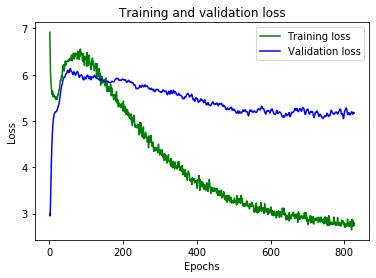

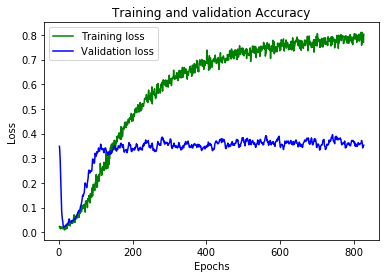

In [4]:
sv.visualize_training()

In [ ]:
# Test
sv.set_gpus("1")
sv.test_generator(sv.test_set)